<a href="https://colab.research.google.com/github/LuFernandez/imagaynes/blob/master/analisis_scripts/rep_imagenes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Scripts y representación de imágenes (Clase 2 y 3)

---



Ezequiel Vijande

Lucero Guadalupe Fernandez

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from IPython.display import clear_output
from scipy import signal
import math

In [2]:
!wget https://raw.githubusercontent.com/lufernandez/imagaynes/master/analisis_scripts/barbara.png
!wget https://raw.githubusercontent.com/lufernandez/imagaynes/master/analisis_scripts/flower.PNG
!wget https://raw.githubusercontent.com/lufernandez/imagaynes/master/analisis_scripts/building.PNG
!wget https://raw.githubusercontent.com/lufernandez/imagaynes/master/analisis_scripts/brain.PNG
!wget https://raw.githubusercontent.com/lufernandez/imagaynes/master/analisis_scripts/pens.jpg

clear_output()

##ex1

In [3]:
def ApplyUnsharp(img, k_size=3):
  kernel = np.array( [ 
      [-0.1667,   -0.6667,   -0.1667],
      [-0.6667,    4.3333,   -0.6667],
      [-0.1667,   -0.6667,   -0.1667]])
  return cv2.filter2D(img,-1,kernel)


def MakeSubplot(img,fig,row,column,index,title):
  fig.add_subplot(row,column,index)
  plt.title(title)
  plt.axis('off')
  plt.imshow(img,cmap='gray', vmin=0)

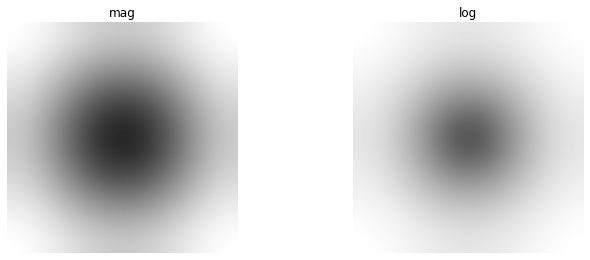

In [4]:
N=256;
big=np.zeros((N,N));       #make a big image
big[N//2][N//2]=1;     #unit impulse

h1 = ApplyUnsharp(big)
S = np.fft.fft2(h1);       #Spectrum
SM=abs(S);          #%Modulo


fig_1 = plt.figure(figsize =(8,8))
plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, hspace = 0.5, wspace = 0.5)

mag=np.fft.fftshift(SM/np.max(np.max(SM)))
MakeSubplot(mag,fig_1,2,2,1, 'mag')

IMd = np.log(1+abs(SM));
log = np.fft.fftshift(IMd/np.max(np.max(IMd)))
MakeSubplot(log,fig_1,2,2,2, 'log')

En primer lugar se crea un filtro pasaaltos. 

A continuación se crea una imagen con un 1 en el (0, 0); una delta, y se convoluciona con el filtro. Al convolucionar la delta con el filtro, éste queda centrado en la imagen de 256x256.

Se calcula la fft de la convolución y se toma su módulo. Luego, se normaliza dividiendo por el máximo de los valores de la fft. La función fftshift(X), swapea el primer cuadrante de X con el tercero, y el segundo con el cuarto, como si invirtiera desde el centro hacia fuera los valores, quedando los valores aumentando hacia y en los bordes; y los valores menores en el centro. Luego se grafican lineal y logarítmicamente. En resumen, lo que se obtiene es la representación en una imagen monocromática de la respuesta en frecuencia del pasaaltos definido al principio. Al aplicar este tipo de filtro sobre una imagen, lo que se obtendría es un efecto de enfoque o sharpen.

##ex2

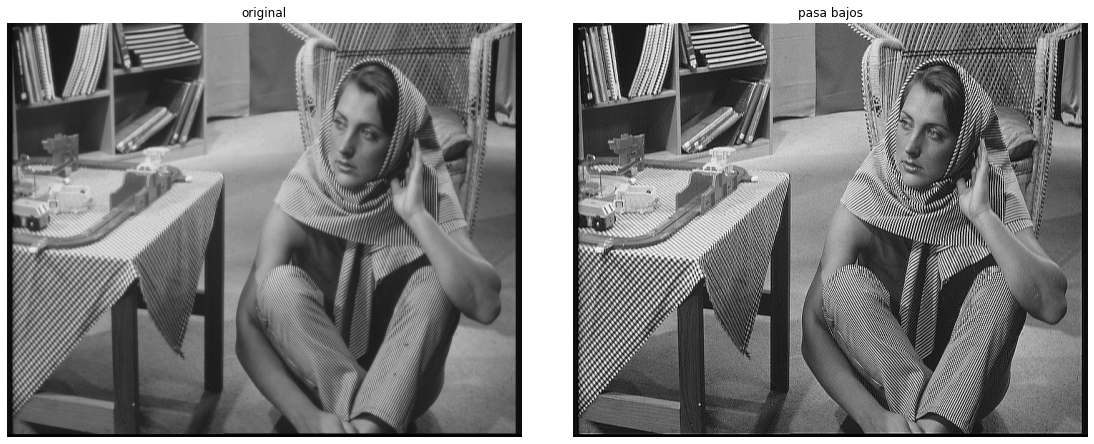

In [5]:
barbs = cv2.imread('barbara.png')
fig_1 = plt.figure(figsize =(15,15))
plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, hspace = 0.5, wspace = 0.1)
MakeSubplot(barbs,fig_1,2,2,1, 'original')

filt = ApplyUnsharp(barbs)
MakeSubplot(filt,fig_1,2,2,2, 'pasa bajos')

Este caso es una aplicación del ejemplo anterior. Se obtiene un filtro highpass (unsharp) y se lo aplica a una imagen, convolucionando la imagen con el filtro mencionado. El resultado final es una imagen enfocada, sharpened.

##spect

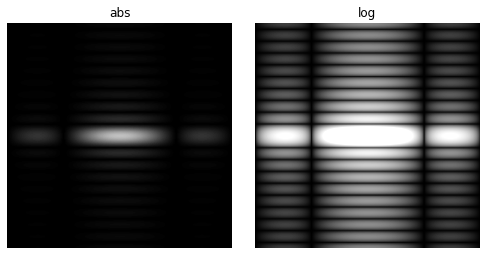

In [6]:

def MakeSubplot(img,fig,row,column,index,title, vmax=255):
  fig.add_subplot(row,column,index)
  plt.title(title)
  plt.axis('off')
  plt.imshow(img,cmap='gray', vmin=0, vmax=vmax)
  
fig_1 = plt.figure(figsize =(10,10))
plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, hspace = 0.5, wspace = 0.1)


f = np.zeros((300,300)) #se cambiaron las dimensiones solo para que se vean mas nitidas las FFTs
f[5:24,13:17] = 1.0


F = np.fft.fft2(f);
F = np.fft.fftshift(F); # Center FFT
mag = np.abs(F).astype(np.int8)
log = np.log(1+np.abs(F))
MakeSubplot(mag,fig_1,2,3,1, 'abs', vmax=100)
MakeSubplot(log,fig_1,2,3,2, 'log', vmax=3)

Se crea una imagen negra con un rectangulo vertical blanco en el centro.
Se realiza el calculo de FFT, y se plotea el módulo y el logaritmo del módulo, como se ve a continuación.


Lo que llama la atención es que en la imagen original el rectángulo sea vertical y los espectros sean horizontales. Esto se puede explicar pensando la FFT como una FFT horizontal y otra vertical. Recorriendo la imagen original de manera horizontal, se puede ver un pulso de período pequeño. Esto en frecuencia es una sinc() con un lóbulo central mayor que el período del pulso en el tiempo. Luego, si recorremos la imagen original de manera vertical, el pulso es de mayor período lo que significa una sinc con un lóbulo central menor en frecuencia. Es decir, son sinc() de frecuencias distintas, porque los pulsos en tiempo son de diferente período.

La motivación para plotear el logaritmo del espectro surge de que el display puede mostrar valores entre 0-255 si se plotea módulo, lo que se puede aprovechar más al calcular el logaritmo de este.

##viasampling

In [120]:
def MakeSubplot(img,fig,row,column,index,title):
  fig.add_subplot(row,column,index)
  plt.title(title)
  plt.axis('off')
  plt.imshow(img,cmap='gray', vmin=0, vmax=255)
  
def downsampling(im,m,filter):
  # Downsample the square image I by a factor of m
  img = np.copy(im)
  N = img.shape[0]
  M = img.shape[1]
  # Apply ideal filter
  w=1/m
  F=np.fft.fftshift(np.fft.fft2(img[:,:,0]))
  if filter == 'FILTER_ON':
    for i in range(N-1):
      for j in range(M-1):
        r2 = (i-N//2)**2+(j-M//2)**2
        if r2 > np.round((N/2*w)*(M/2*w)):
          F[i][j]=0 
  
  img_d=np.real(np.fft.ifft2(np.fft.ifftshift(F)))
  #% Now downsample
  img_d=cv2.resize(img_d, (N//m,N//m), interpolation=cv2.INTER_NEAREST) 
  img_d[img_d > 255.0] = 255.0
  img_d[img_d < 0 ] = 0.0
  img_d = np.uint8(img_d)
  return img_d

def upsampling(img,m):
  #Upsample the square image I by a factor of m
  N = img.shape[0]
  M = img.shape[1]
  imgup=np.zeros((m*N,m*M))
  #% Expand input image
  for i in range(N):
    for j in range(M):
      imgup[m*i+1,m*j+1] = img[i][j]
  #imgup[imgup > 255.0] = 255.0
  #imgup[imgup < 0.0 ] = 0.0
  
  #% Ideal filter
  N = imgup.shape[0]
  M = imgup.shape[1]
  w=1/m
  F=np.fft.fftshift(np.fft.fft2(imgup))
  for i in range(N):
    for j in range(M):
      r2 = (i-np.round(N/2))**2+(j-np.round(M/2))**2
      if r2 > np.round((N/2*w)*(M/2*w)): 
        F[i,j] = 0

  Iup = (m*m)*np.real(np.fft.ifft2(np.fft.ifftshift(F)))
  Iup[Iup > 255.0] = 255.0
  Iup[Iup < 0 ] = 0.0
  return np.uint8(Iup)

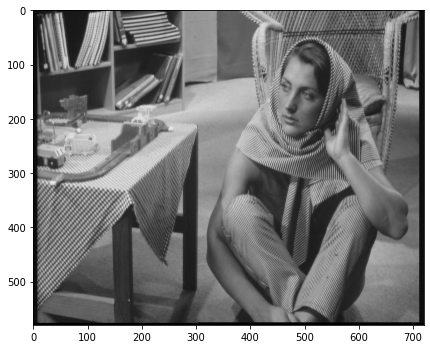

In [126]:
barbs = cv2.imread('barbara.png')
fig_1 = plt.figure(figsize =((7,7)))
plt.imshow(barbs, cmap='gray')

m=2

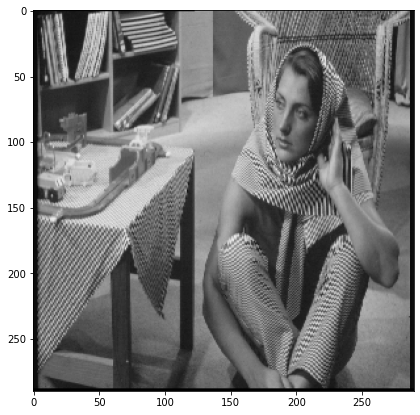

In [127]:
barbs_d=downsampling(barbs,m,'FILTER_OFF')
fig_2 = plt.figure(figsize =(7,7))
plt.imshow(barbs_d, cmap='gray', vmin=0, vmax=255)

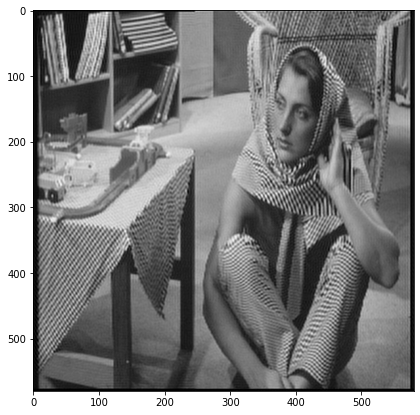

In [128]:
barbs_u=upsampling(barbs_d,m)
fig_3 = plt.figure(figsize =(7,7))
plt.imshow(barbs_u, cmap='gray', vmin=0, vmax=255)

##myallias

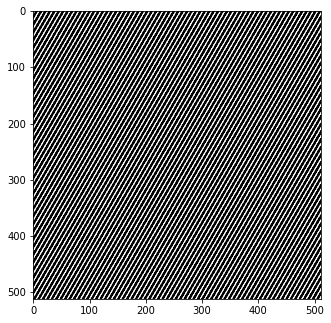

In [148]:
#fig_1 = plt.figure(figsize =(6,6))
plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, hspace = 0.5, wspace = 0.1)

xsize, ysize = 512, 512
alpha1 = -np.pi/6
alpha2 = np.pi/6
f1,f2 = 75, 75

a1, a2 = 1, 1
phase1, phase2 = 0, 0

X, Y = np.meshgrid(np.linspace(0,xsize,512)/512, np.linspace(0,ysize,512)/512)
grid1 = math.cos(alpha1)*X + math.sin(alpha1)*Y
grid2 = math.cos(alpha2)*X + math.sin(alpha2)*Y
img = np.zeros((xsize, ysize))
for i in range(len(X)):
    for j in range(len(Y)):
      img[i][j] = np.sign(a1*math.sin(2*np.pi*f1*grid1[i][j] + phase1))*255


for i in range(len(X)):
    for j in range(len(Y)):
      img[i][j] = np.sign(a2*math.sin(2*np.pi*f2*grid2[i][j] + phase2))*255


plt.imshow(img,cmap='gray', vmin=0, vmax=255)

Se crea una imagen con una frecuencia espacial en diagonal en sentido noroeste y luego otra en sentido noreste. Tenemos entonces dos frecuencias.

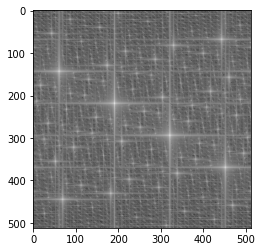

In [158]:
#fig_1 = plt.figure(figsize =(8,8))
IM = np.fft.fftshift(np.fft.fft2(img))
IMd = np.log10(1+np.abs(IM))
plt.imshow(IMd/IMd.max(), cmap='gray')

Lo que se ve en el espectro son dos 'deltas' que son las frecuencias que elegimos, y es la representación en frecuencia de un seno. Pero también hay otras frecuencias que se observan en el espectro que se deben a leakage espectral por haber ventaneado con ventana rectangular.

Se ven unas estrellas

#Representación de imágenes

###decimación

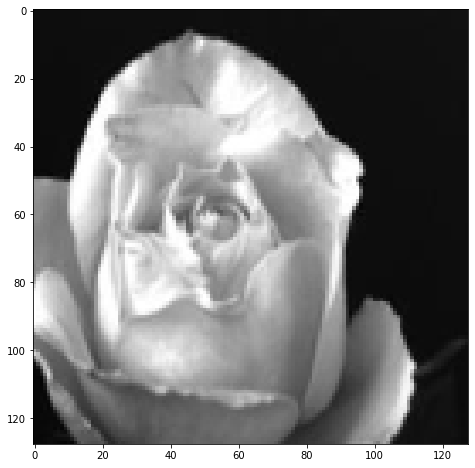

In [11]:
flo = cv2.imread('flower.PNG')

#tomo 256x256 pixeles (la imagen era menor a 512x512 pixeles)
flo = flo[100:356,100:356]

def subsample(im, N):
  img = np.zeros((im.shape[0]//N,im.shape[1]//N, 3))
  for i in range(im.shape[0]//N):
    for j in range(im.shape[1]//N):
      img[i][j] = im[i*N][j*N]
  return img


# def subsample(im, N):
#   img = np.zeros((im.shape[0],im.shape[1], 3))
#   step = 4
#   x_pos = 0
#   y_pos = 0
#   for row in range(0, im.shape[0], step):
#     for col in range(0, im.shape[1], step):
#       new_pixel = im[row+x_pos, col+y_pos]
#       img[row//step, col//step] = new_pixel
#   return img[0:im.shape[0]//N,0:im.shape[1]//N]



img = np.uint8(subsample(flo, 2))
fig_1 = plt.figure(figsize=(8,8))
plt.imshow(img, cmap='gray', vmin=0, vmax=255)

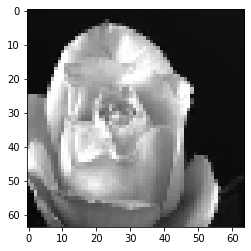

In [12]:
img = np.uint8(subsample(flo, 4))
fig_1 = plt.figure(figsize =(4,4))
plt.imshow(img, cmap='gray', vmin=0, vmax=255)

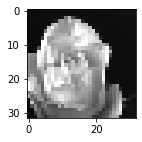

In [13]:
img = np.uint8(subsample(flo, 8))
fig_1 = plt.figure(figsize =(2,2))
plt.imshow(img, cmap='gray', vmin=0, vmax=255)

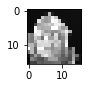

In [14]:
img = np.uint8(subsample(flo, 16))
fig_1 = plt.figure(figsize =(1,1))
plt.imshow(img, cmap='gray', vmin=0, vmax=255)

###Decimación manteniendo el tamaño de la imagen

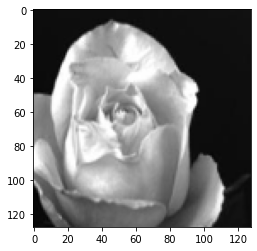

In [15]:
flo = cv2.imread('flower.PNG')

#tomo 256x256 pixeles (la imagen era menor a 512x512 pixeles)
flo = flo[100:356,100:356]

def subsample(im, N):
  img = np.zeros((im.shape[0]//N,im.shape[1]//N, 3))
  for i in range(im.shape[0]//N):
    for j in range(im.shape[1]//N):
      img[i][j] = im[i*N][j*N]
  return img

img = np.uint8(subsample(flo, 2))
plt.imshow(img, cmap='gray', vmin=0, vmax=255)

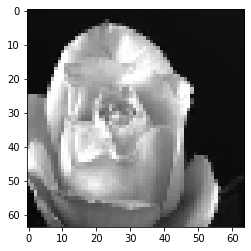

In [16]:
img = np.uint8(subsample(flo, 4))
plt.imshow(img, cmap='gray', vmin=0, vmax=255)

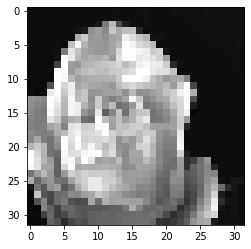

In [17]:
img = np.uint8(subsample(flo, 8))
plt.imshow(img, cmap='gray', vmin=0, vmax=255)

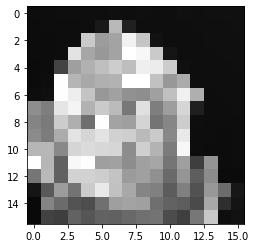

In [18]:
img = np.uint8(subsample(flo, 16))
plt.imshow(img, cmap='gray', vmin=0, vmax=255)

###Decimación 256x192

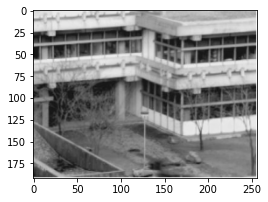

In [19]:
b = cv2.imread('building.PNG')
b = cv2.resize(b, (256, 192))

def subsample(im, N):
  img = np.zeros((im.shape[0]//N,im.shape[1]//N, 3))
  for i in range(im.shape[0]//N):
    for j in range(im.shape[1]//N):
      img[i][j] = im[i*N][j*N]
  return img

#img = np.uint8(subsample(b, 2))
fig_1 = plt.figure(figsize=(4,4))
plt.imshow(b, cmap='gray', vmin=0, vmax=255)

###Decimación 64x48

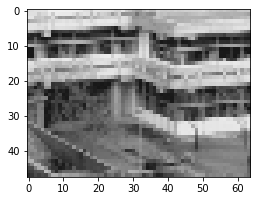

In [20]:
img = np.uint8(subsample(b, 4))
fig_1 = plt.figure(figsize=(4,4))
plt.imshow(img, cmap='gray', vmin=0, vmax=255)

###Muestreo

[  0  36  72 109 145 182 218 255]
[  0  85 170 255]
[  0 255]


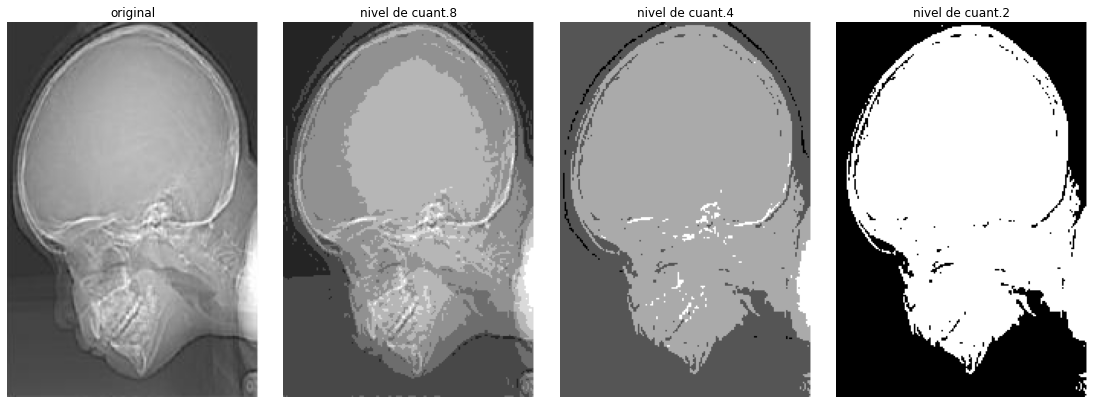

In [21]:
brain = cv2.imread('brain.PNG')
fig_1 = plt.figure(figsize =(15,15))
plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, hspace = 0.5, wspace = 0.1)
MakeSubplot(brain,fig_1, 1, 4, 1, 'original')

def sample(img, n = 2):
  new_img = np.copy(img)
  gray_levels = np.linspace(start=0,stop=255,num=n,dtype=int)
  print(gray_levels)
  for row in range(0,new_img.shape[0]):
    for col in range(0,new_img.shape[1]):
      index = (np.abs(gray_levels - img[row][col][0])).argmin()
      new_img[row][col] =  gray_levels[index]
  return new_img



levels = [8,4,2]

for i in range(len(levels)):
  brain_= sample(brain, n = levels[i])
  MakeSubplot(brain_,fig_1,1,4,i+2,title='nivel de cuant.'+str(levels[i]))